In [451]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket
from datetime import datetime
import numpy as np
import scipy
import matplotlib.pyplot as plt
from qibo import hamiltonians

## Theoretical check

$$
H\otimes H e^{it Z\otimes Z}H\otimes H = X\otimes X ?
$$

Constructing a XX unitary and compare with one with ZZ.

In [395]:
# obtain e^{itX\otimes X} unitary
# Define the Pauli-X matrix
import scipy.linalg


X = np.array([[0, 1],
              [1, 0]], dtype=complex)

# Compute the tensor product X ⊗ X
XX = np.kron(X, X)

# Define the parameter t
t = np.pi / 6  # You can choose any real value for t

# Compute the unitary matrix U = e^{i t X⊗X}
U1 = scipy.linalg.expm(1j * t * XX)


In [396]:
# define the tensor hadamard unitary
H = 1/np.sqrt(2) * np.array([[1,1],
                             [1,-1]], dtype=complex)
Z = np.array([[1, 0],
              [0, -1]], dtype=complex)
HH = np.kron(H, H)
ZZ = np.kron(Z, Z)
U2 = HH @ scipy.linalg.expm(1j * t * ZZ) @ HH

In [397]:
np.linalg.norm(U1-U2)

9.496780065728157e-16

## Circuit implementation

From the above test, we see that theoretically, the decomposition is correct. Now we will build the pytket circuit for this decomposition.

According to the documentation: https://docs.quantinuum.com/h-series/trainings/getting_started/pytket_quantinuum/Quantinuum_arbitrary_angle_zz.html, the arbitrary angle ZZ gate in pytket is defined as
$$
RZZ(\alpha) = e^{-i\frac{\alpha}{2}Z\otimes Z}
$$

However, it is actually
$$
RZZ(\alpha) = e^{-i\frac{\alpha\pi}{2}Z\otimes Z}
$$

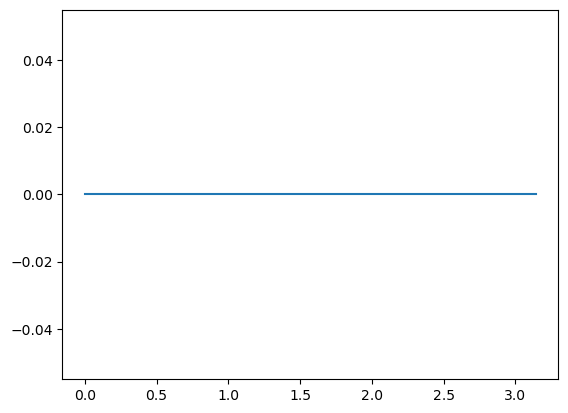

In [398]:
## RZZ in pytket
diff = []
t_range = np.linspace(0, np.pi, 10)
for t in t_range:
    ZZ_evol = scipy.linalg.expm(1j * t * ZZ)
    c = Circuit(2)
    c.ZZPhase(-t*2/np.pi, 0, 1)
    diff.append(np.linalg.norm(ZZ_evol-c.get_unitary()))
    
plt.plot(t_range, diff)
    

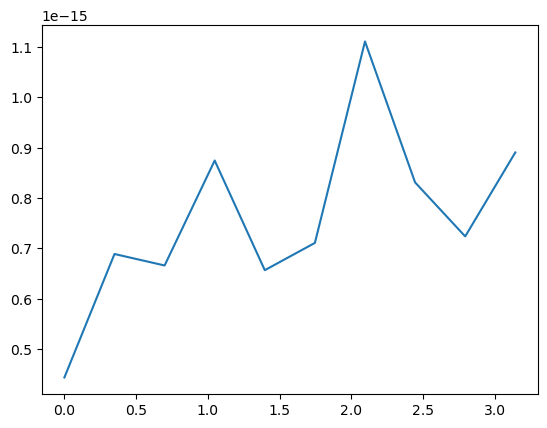

In [399]:
# compare our target circuit
diff = []
t_range = np.linspace(0, np.pi, 10)
for t in t_range:
    U1 = scipy.linalg.expm(1j * t * XX)
    circuit1 = Circuit(2)
    circuit1.H(0)
    circuit1.H(1)
    circuit1.ZZPhase(-t*2/np.pi, 0, 1)
    circuit1.H(0)
    circuit1.H(1)
    U2 = circuit1.get_unitary()
    diff.append(np.linalg.norm(U1-U2))
plt.plot(t_range, diff)

## XXZ model

Now we will use native gates to simulate the XXZ hamiltonian given by
$$
H_ = \sum _{k=0}^L \left( X_{k} X_{k + 1} + Y_{k} Y_{k + 1} + \delta Z_{k}Z_{k + 1} \right)
$$

Let's first consider the case with 2 qubit, since terms commute, the same strategy will apply to cases with more qubits.

Because the terms $X\otimes X$, $Y\otimes Y$, and $Z\otimes Z$ commute, we can write
$$
e^{it(XX+YY+ZZ)} = e^{itXX}e^{itYY}e^{itZZ}
$$

Then we have
$$
e^{itXX}=H\otimes H e^{itZZ}
$$
$$
e^{itYY}=(S\otimes S)(H\otimes H) e^{itZZ}(H\otimes H)(S^\dag\otimes S^\dag)
$$

Note that qibo.hamiltonians.XXZ for 2 qubits, there is an extra factor 2, that is QIBO_XXZ = 2 * XXZ.


Constructing an open boundary condition XXZ model (qibo XXZ uses periodic boundary condition)

In [555]:
from qibo.symbols import X, Y, Z
def construct_XXZ(nqubits, delta=0.5, boundary='open'):
    if boundary == 'periodic' or boundary == 'closed':
        return hamiltonians.XXZ(nqubits, delta).matrix
    elif boundary == 'open':
        H_sym = sum([X(i)*X(i+1)+ Y(i)*Y(i+1) + delta* Z(i)*Z(i+1) for i in range(nqubits-1)])
        return hamiltonians.SymbolicHamiltonian(H_sym).matrix

### Construct 2 qubit XXZ

In [491]:
t = np.pi/6
delta = 0.5
H = construct_XXZ(2, delta)
U1 = scipy.linalg.expm(1j*t*H)

In [492]:
t = np.pi/6
delta = 0.5
qc = Circuit(2)
# implement xx
qc.H(0), qc.H(1)
qc.ZZPhase(-t*2/np.pi, 0, 1)
qc.H(0), qc.H(1)

# implement yy
qc.Sdg(0), qc.Sdg(1)
qc.H(0), qc.H(1)
qc.ZZPhase(-t*2/np.pi, 0, 1)
qc.H(0), qc.H(1)
qc.S(0), qc.S(1)

# implement zz
qc.ZZPhase(-t*2/np.pi * delta, 0, 1)
U2 = qc.get_unitary

In [493]:
# render_circuit_jupyter(qc)

In [494]:
np.linalg.norm(U1-U2)

1.486673200195252e-15

## Check for n qubits XXZ

In this section, we check that the product formula converges to n qubit XXZ model evolution with Trotter-Suzuki formula.
To do this, we divide the interaction into odd and even sub-lattices.
i.e. [1,2], [3,4], [5,6] being `c_odd` and [2,3], [4,5] being `c_even`.
This way, we can run the non-interacting pairs simultaneously.


In [594]:
def XX_interaction(qc, q0, q1, t):
    qc.H(q0), qc.H(q1)
    qc.ZZPhase(t*2/np.pi, q0, q1)
    qc.H(q0), qc.H(q1)

def YY_interaction(qc, q0, q1, t):
    qc.Sdg(q0), qc.Sdg(q1)
    XX_interaction(qc, q0, q1, t)
    qc.S(q0), qc.S(q1)

def ZZ_interaction(qc, q0, q1, t):
    qc.ZZPhase(t*2/np.pi, q0, q1)

We consider 2 ways of decomposing the XXZ terms:
1. 2 layers:
2. 3 layers

In [530]:
def XXZ_decomposition(nqubits, t, delta=0.5, qc=None, layer=2, boundary='open'):
    # This function generates the circuit that simulates e^{itH}
    # where H is the XXZ model
    # nqubits must be equal or greater than 2
    def generate_adjacent_pairs(n):
        if n < 2:
            raise ValueError("Input nqubits must be equal to or larger than 2.")
        even_starting_pairs = [[s, s+1] for s in range(0, n-1, 2)]
        odd_starting_pairs = [[s, s+1] for s in range(1,n-1, 2)]
        if boundary == 'periodic' or boundary == 'closed':
            # print('periodic case')
            if nqubits % 2 == 0:
                # even number of qubits add to odd pairs
                odd_starting_pairs.append([0, nqubits-1])
            else:
                even_starting_pairs.append([0, nqubits-1])
                # note that odd number of qubits result in degenerate ground states
        return even_starting_pairs, odd_starting_pairs
    even_starting_pairs, odd_starting_pairs = generate_adjacent_pairs(nqubits)
    if qc is None:
        qc = Circuit(nqubits) 
    if layer == 2:
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta)
        for q0, q1 in odd_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta) 
    elif layer == 3:
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t/2)
            YY_interaction(qc, q0, q1, t/2)
            ZZ_interaction(qc, q0, q1, t*delta/2)
        for q0, q1 in odd_starting_pairs:
            XX_interaction(qc, q0, q1, t)
            YY_interaction(qc, q0, q1, t)
            ZZ_interaction(qc, q0, q1, t*delta) 
        for q0, q1 in even_starting_pairs:
            XX_interaction(qc, q0, q1, t/2)
            YY_interaction(qc, q0, q1, t/2)
            ZZ_interaction(qc, q0, q1, t*delta/2)
    else:
        raise ValueError("Number of layers not supported, use either '2' or '3'.")
    return qc

In [531]:
XXZ_decomposition(3, np.pi/2)

[H q[0]; H q[1]; H q[2]; ZZPhase(3) q[0], q[1]; H q[0]; H q[1]; Sdg q[0]; Sdg q[1]; H q[0]; H q[1]; ZZPhase(3) q[0], q[1]; H q[0]; H q[1]; S q[0]; S q[1]; ZZPhase(3.5) q[0], q[1]; H q[1]; ZZPhase(3) q[1], q[2]; H q[1]; H q[2]; Sdg q[1]; Sdg q[2]; H q[1]; H q[2]; ZZPhase(3) q[1], q[2]; H q[1]; H q[2]; S q[1]; S q[2]; ZZPhase(3.5) q[1], q[2]; ]

Double check whether the tensor product approach gives the same unitary as QIBO model.

In [532]:
H_qibo = hamiltonians.XXZ(8, 0.5).matrix
H_tensor = construct_XXZ(8, 0.5, 'periodic')
print(np.linalg.norm(H_qibo - H_tensor))

0.0


Let's first fix the time and evaluate the error as we increase the number of qubits.

In [595]:
test_qubits = [2,3,4,5,6,7,8,9,10]
t = np.pi/6
U1 = [scipy.linalg.expm(-1j*t*(construct_XXZ(n,delta))) for n in test_qubits]
U2 = [XXZ_decomposition(n, t, delta).get_unitary() for n in test_qubits]
U3 = [XXZ_decomposition(n, t, delta, layer=3).get_unitary() for n in test_qubits]
diff_12 = [np.linalg.norm(U1[i]-U2[i]) for i in range(len(test_qubits))]
diff_13 = [np.linalg.norm(U1[i]-U3[i]) for i in range(len(test_qubits))]

[Qibo 0.2.13|WARNING|2025-01-22 16:15:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:38]: Calculating 

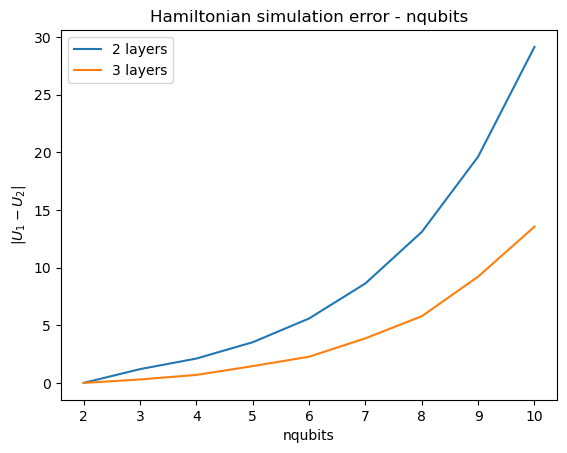

In [596]:
plt.plot(test_qubits, diff_12, label='2 layers')
plt.plot(test_qubits, diff_13, label='3 layers')
plt.xlabel('nqubits')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - nqubits')
plt.legend()

Now we fix nqubits and vary time.

In [597]:
nqubits = 6
test_t = np.linspace(0, np.pi/20, 30)
U1 = [scipy.linalg.expm(-1j*t*(construct_XXZ(nqubits,delta))) for t in test_t]
U2 = [XXZ_decomposition(nqubits, t, delta).get_unitary() for t in test_t]
U3 = [XXZ_decomposition(nqubits, t, delta, layer=3).get_unitary() for t in test_t]
diff_12 = [np.linalg.norm(U1[i]-U2[i]) for i in range(len(test_t))]
diff_13 = [np.linalg.norm(U1[i]-U3[i]) for i in range(len(test_t))]

[Qibo 0.2.13|WARNING|2025-01-22 16:15:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:53]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.13|WARNING|2025-01-22 16:15:53]: Calculating 

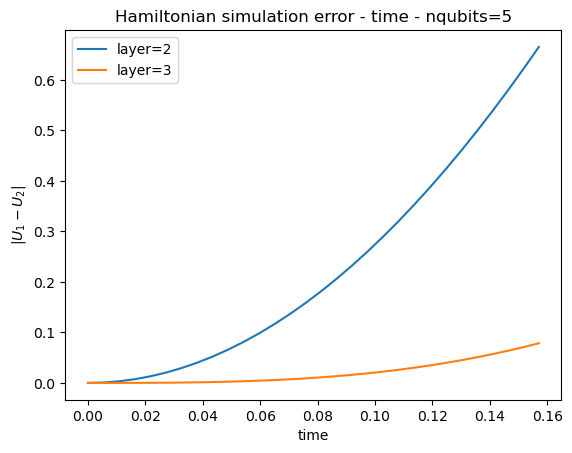

In [598]:
plt.plot(test_t, diff_12, label='layer=2')
plt.plot(test_t, diff_13, label='layer=3')
# plt.yscale('log')
plt.xlabel('time')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - time - nqubits=5')
plt.legend()

Next, we see how trotterization reduces the error when we fix the time.

In [599]:
t = np.pi/20
nqubits = 6
n_trotter = 10
U1 = scipy.linalg.expm(-1j*t*(construct_XXZ(nqubits, delta)))

[Qibo 0.2.13|WARNING|2025-01-22 16:16:00]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [600]:
def trotter_circuit(nqubits, t, n_trotter, layer=2):
    qc = Circuit(nqubits)
    dt = t/n_trotter
    for n in range(n_trotter):
        qc = XXZ_decomposition(nqubits, dt, delta, qc, layer=layer)
    return qc

In [601]:
U2 = [trotter_circuit(nqubits, t, n).get_unitary() for n in range(1, n_trotter)]
U3 = [trotter_circuit(nqubits, t, n, layer=3).get_unitary() for n in range(1, n_trotter)]
diff_12 = [np.linalg.norm(U1-U2[i]) for i in range(n_trotter-1)]
diff_13 = [np.linalg.norm(U1-U3[i]) for i in range(n_trotter-1)]

Text(0.5, 1.0, 'Hamiltonian simulation error - trotter steps')

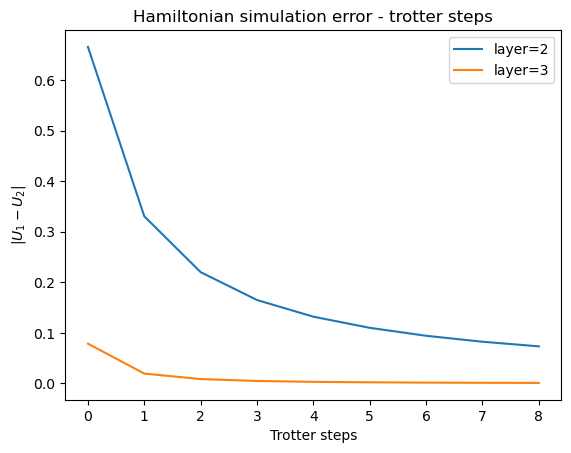

In [602]:
plt.plot(diff_12, label='layer=2')
plt.plot(diff_13, label='layer=3')
plt.legend()
plt.xlabel('Trotter steps')
plt.ylabel(r'$|U_1-U_2|$')
plt.title('Hamiltonian simulation error - trotter steps')

## One step of DBQA

Now we have seen that using S, H, and ZZ gates, we are able to simulate the XXZ hamiltonian.
Note that for simplicity of implementation, we will be using the periodic boundary condition XXZ.

Recall that a double-bracket-rotation is given by

$$
H_{k+1} = e^{s_kW_k}H_ke^{-s_kW_k}
$$

where $s$ is the rotation duration, the rotation generator $W_k:=[D_k, H_k]$, and $D_k$ is a diagonal operator. 

The reduced group commutator is given by
$$P_k = e^{is D_k} e^{is H_k} e^{-isD_k}$$

$$V_1 = e^{-itD}U_\theta^\dag e^{-itH}U_\theta e^{itD}$$

$$U_1 = U_\theta * V_1$$

$$ |\psi_1(\theta)\rang = U_1|0\rang$$

After dropping a global phase,

$$ |\psi_1(\theta)\rang = U_\theta e^{-itD}U_\theta^\dag e^{-itH}U_\theta|0\rang$$

We use 8 qubits as an example.
1. Train VQE circuit get unitary
2. Train GCI get a good D operator
3. Get the expectation of U1

In [614]:
# Load the VQE circuit
optimizer = 'sgd'
nqubits = 8
nlayer = 1
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ.qasm'
vqe_circ = pytket.qasm.circuit_from_qasm(vqe_circ_file)
vqe_circ_inverse = vqe_circ.dagger()
V = vqe_circ.get_unitary()
V_dag = V.T.conjugate()
# check unitary
print(np.linalg.norm(V@V_dag-np.eye(2**8)))

1.3982321753245726e-14


In this primative example notebook, we will use a $D$ operator generated from the
MagneticFieldOracle.
To see how the below values were obtained, check out:
https://github.com/qiboteam/boostvqe/blob/a6706911088f79f02ef2592eb68aec70450145d2/notebooks/gci_boostvqe_circuit_synthesis.ipynb 

In [615]:
d_params = np.asarray([0.   , 0.95462806, 1.22359112, 0.76825245, 0.98561508, 1.13887971, 0.46554814, 1.65172204])
s = 0.02

Now we shall create a circuit of 
$$
e^{-itD}
$$

Note that pytket $Rz(\alpha)=e^{-\frac{i}{2}\pi \alpha Z}$

In [616]:
def magnetic_field(coefs, t):
    # implments e^{-itD}
    nqubits = len(coefs)
    qc = Circuit(nqubits)
    
    for idx, coef in enumerate(coefs):
        theta = 2 * t * coef / np.pi
        qc.Rz(theta, idx)
    return qc    

# check for 1 qubit case
Z_matrix = np.array([[1, 0],
              [0, -1]], dtype=complex)
H1 = scipy.linalg.expm(-1j*0.4*Z_matrix)
H2 = magnetic_field([1], 0.4).get_unitary()
print(np.linalg.norm(H1-H2))

7.850462293418876e-17


In [632]:
# compose the circuit
from copy import deepcopy
t = s
sequence = [i for i in range(nqubits)]
D_circ = magnetic_field(d_params, t)
D_circ_inverse = D_circ.dagger()
qc = deepcopy(D_circ)
qc.add_circuit(vqe_circ, sequence)
qc.add_circuit(XXZ_decomposition(nqubits, s, layer=3, boundary='periodic'), sequence)
qc.add_circuit(vqe_circ_inverse, sequence)
qc.add_circuit(magnetic_field(d_params, t), sequence)
qc.add_circuit(vqe_circ, sequence)
# render_circuit_jupyter(qc)

[Rz(0) q[0]; Rz(0.0121547) q[1]; Rz(0.0155792) q[2]; Rz(0.00978169) q[3]; Rz(0.0125492) q[4]; Rz(0.0145007) q[5]; Rz(0.00592754) q[6]; Rz(0.0210304) q[7]; Ry(0.355549) q[0]; Ry(3.11015) q[1]; Ry(0.239779) q[2]; Ry(0.0656993) q[3]; Ry(0.19457) q[4]; Ry(3.82272) q[5]; Ry(3.7857) q[6]; Ry(1.02313) q[7]; Rz(3.28431) q[0]; Rz(3.15169) q[1]; Rz(0.374032) q[2]; Rz(1.00881) q[3]; Rz(2.99712) q[4]; Rz(0.00216184) q[5]; Rz(0.981106) q[6]; Rz(0.346647) q[7]; CZ q[0], q[1]; CZ q[2], q[3]; CZ q[4], q[5]; CZ q[6], q[7]; Ry(0.204027) q[0]; Ry(3.47781) q[1]; Ry(0.992696) q[2]; Ry(0.286101) q[3]; Ry(3.75019) q[4]; Ry(3.58948) q[5]; Ry(3.44284) q[6]; Ry(0.214782) q[7]; Rz(3.75672) q[0]; Rz(3.97669) q[1]; Rz(0.381481) q[2]; Rz(0.00196058) q[3]; Rz(0.00153383) q[4]; Rz(3.99905) q[5]; Rz(1.02162) q[6]; Rz(3.97719) q[7]; CZ q[0], q[7]; CZ q[1], q[2]; CZ q[3], q[4]; CZ q[5], q[6]; Ry(0.976869) q[0]; Ry(3.91055) q[1]; Ry(3.44054) q[2]; Ry(3.42434) q[3]; Ry(2.88317) q[4]; Ry(0.90495) q[5]; Ry(3.43717) q[6]; Ry

Here we do an analytical comparison of the new GCI expectation vs VQE vs target expectation of ground state.
For a circuit with unitary $U$ and Hamiltonian $H$, we have
$$
\langle H\rangle =\langle 0|U^\dagger H U|0\rangle
$$

In [623]:
def unitary_expectation(U, H, ket0=None):
    if ket0 is None:
        ket0 = np.zeros((U.shape[0],), dtype=complex)
        ket0[0] = 1.0
    psi = U @ ket0
    return np.vdot(psi, H @ psi).real

In [633]:
H = hamiltonians.XXZ(nqubits, delta, dense=False)
ket0 = H.backend.zero_state(nqubits)
target_energy = np.real(np.min(np.asarray(H.eigenvalues())))
vqe_energy = unitary_expectation(V, H.matrix, ket0)
dbqa_energy = unitary_expectation(qc.get_unitary(), H.matrix, ket0)
print('Target enegry:', target_energy)
print('VQE energy:', vqe_energy)
print('DBQA energy:', dbqa_energy)

[Qibo 0.2.13|WARNING|2025-01-22 17:31:39]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


Target enegry: -12.347977420549505
VQE energy: -10.57945304803128
DBQA energy: 0.2348376729859957


# Execution on Quantinuum

# 